## Multi-label classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [3]:
PATH = 'data/planet/'

In [4]:
# Data preparation steps if you are using Crestle:

os.makedirs('data/planet/models', exist_ok=True)
os.makedirs('/cache/planet/tmp', exist_ok=True)

!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train-jpg {PATH}
!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/test-jpg {PATH}
!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train_v2.csv {PATH}
!ln -s /cache/planet/tmp {PATH}

ln: failed to create symbolic link 'data/planet/train-jpg': No such file or directory
ln: failed to create symbolic link 'data/planet/test-jpg': No such file or directory
ln: failed to create symbolic link 'data/planet/train_v2.csv': No such file or directory
ln: failed to create symbolic link 'data/planet/tmp': No such file or directory


In [5]:
ls {PATH}

Parameter format not correct - "planet".


## Multi-label versus single-label classification

In [9]:
from fastai.plots import *

In [10]:
def get_1st(path): return glob(f'{path}/*.*')[0]

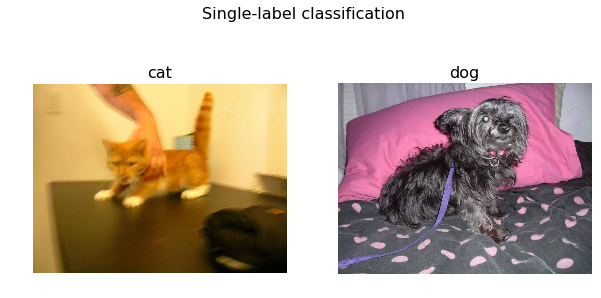

In [11]:
dc_path = "data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label classification")

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

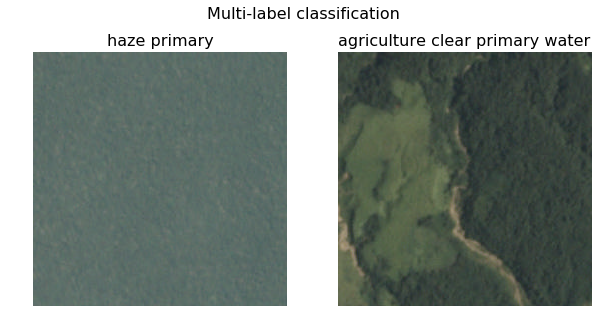

In [13]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: *haze* and *primary*. The second image belongs to four clases: *agriculture*, *clear*, *primary* and  *water*.

## Multi-label models for Planet dataset

In [16]:
from planet import f2

metrics=[f2]
f_model = resnet34

In [17]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [18]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [19]:
data = get_data(256)

In [20]:
x,y = next(iter(data.val_dl))

In [21]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [22]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

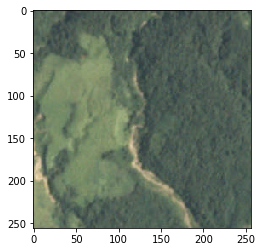

In [23]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [24]:
sz=64

In [25]:
data = get_data(sz)

In [26]:
data = data.resize(int(sz*1.3), 'tmp')

In [27]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

epoch      trn_loss   val_loss   f2                          
    0      0.218386   0.212016   0.841793  



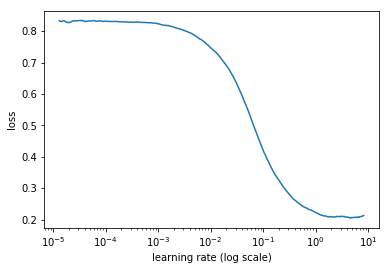

In [28]:
lrf=learn.lr_find()
learn.sched.plot()

In [29]:
lr = 0.2

In [30]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.148152   0.134649   0.88333   
    1      0.140678   0.12891    0.888419                    
    2      0.140432   0.127094   0.889025                    
    3      0.138668   0.127203   0.887458                    
    4      0.133545   0.124519   0.891422                    
    5      0.135575   0.12308    0.893947                    
    6      0.131338   0.123128   0.893075                    



[array([0.12313]), 0.8930749069166287]

In [31]:
lrs = np.array([lr/9,lr/3,lr])

In [32]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.121435   0.110443   0.907641  
    1      0.121007   0.105911   0.91111                     
    2      0.11066    0.102755   0.91255                     
    3      0.112738   0.103701   0.912458                    
    4      0.108179   0.100939   0.913467                    
    5      0.101386   0.098393   0.916934                     
    6      0.102643   0.097652   0.917416                     



[array([0.09765]), 0.9174159856712344]

In [33]:
learn.save(f'{sz}')

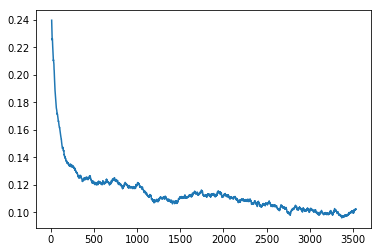

In [34]:
learn.sched.plot_loss()

In [35]:
sz=128

In [36]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.09983    0.097438   0.915391  
    1      0.097168   0.0967     0.915103                     
    2      0.096884   0.095577   0.918052                     
    3      0.096158   0.094365   0.918737                     
    4      0.09835    0.09432    0.918                        
    5      0.095799   0.093579   0.919197                     
    6      0.094926   0.093625   0.919242                     



[array([0.09363]), 0.919241681904715]

In [37]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

epoch      trn_loss   val_loss   f2                           
    0      0.093273   0.088952   0.925337  
    1      0.095053   0.088894   0.925012                     
    2      0.08771    0.086344   0.928111                     
    3      0.093769   0.088764   0.92478                      
    4      0.090045   0.087288   0.926036                     
    5      0.087886   0.085741   0.928046                     
    6      0.085017   0.085154   0.929141                     



In [38]:
sz=256

In [39]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.091337   0.089123   0.92446   
    1      0.090214   0.088467   0.925585                     
    2      0.085737   0.087448   0.926938                     
    3      0.089169   0.088125   0.925372                     
    4      0.090392   0.087319   0.927246                     
    5      0.08863    0.086819   0.927129                     
    6      0.085711   0.087058   0.9267                       



[array([0.08706]), 0.9266999584983603]

In [40]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

epoch      trn_loss   val_loss   f2                           
    0      0.087114   0.082997   0.932217  
    1      0.087611   0.083829   0.930119                     
    2      0.08521    0.082146   0.932055                     
    3      0.086491   0.08395    0.930949                     
    4      0.081053   0.082378   0.932177                     
    5      0.07946    0.081524   0.933082                     
    6      0.074787   0.081757   0.932438                     



In [41]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [42]:
f2(preds,y)

0.9305992322395517

### End